In [28]:
import networkx as nx
import matplotlib.pyplot as plt

n = 15      # number of demand points

depot = 0
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1,nx.DiGraph())

In [29]:
# for convenience, pick the city (x,y)-coordinates at random
import random
my_pos = { i : ( random.randint(1,50), random.randint(1,50) ) for i in dem_points } # pos[i] = (x_i, y_i)
# let's locate the depot in the middle
my_pos[depot] = (25, 25)

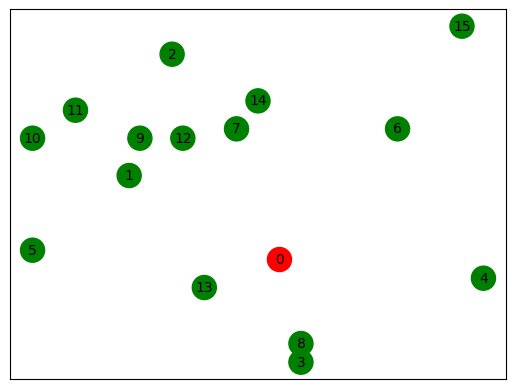

In [30]:
color_map = []
for node in G:
    if node == 0:
        color_map.append('red')
    else:
        color_map.append('green')
nx.draw_networkx_nodes(G, node_color=color_map, pos=my_pos)
nx.draw_networkx_labels(G, pos=my_pos, font_size=10, font_color='black')
plt.show()

In [31]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [32]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : random.randint(10,20) for i in dem_points }
print(q)

{1: 11, 2: 13, 3: 19, 4: 10, 5: 13, 6: 20, 7: 18, 8: 14, 9: 14, 10: 19, 11: 20, 12: 20, 13: 13, 14: 20, 15: 16}


In [33]:
total_demand = sum(q.values())
print(f"The total demand is: {total_demand}")

The total demand is: 240


In [34]:
#total number of vehicles
k = int((total_demand/100) + 1)

print(f"""
The total demand is: {total_demand}
The minimum number of vehicles required are: {k}
""")


The total demand is: 240
The minimum number of vehicles required are: 3



In [35]:
import gurobipy as gp
from gurobipy import GRB

In [36]:
# First, solve a relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Enter each demand point once
m.addConstrs( gp.quicksum( x[i,j] for i in G.predecessors(j) ) == 1 for j in dem_points )

# Leave each demand point once
m.addConstrs( gp.quicksum( x[i,j] for j in G.successors(i) ) == 1 for i in dem_points )

# Leave the depot k times
m.addConstr( gp.quicksum( x[depot,j] for j in G.successors(depot) ) == k )

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31 rows, 240 columns and 465 nonzeros
Model fingerprint: 0xc2d1017e
Variable types: 0 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 368.9463218
Presolve time: 0.02s
Presolved: 31 rows, 240 columns, 465 nonzeros
Variable types: 0 continuous, 240 integer (240 binary)

Root relaxation: objective 1.647378e+02, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     164.7378149  164.73781  0.00%     -    0s

Explored 1 nodes (37 simplex iterations) in 0.07 

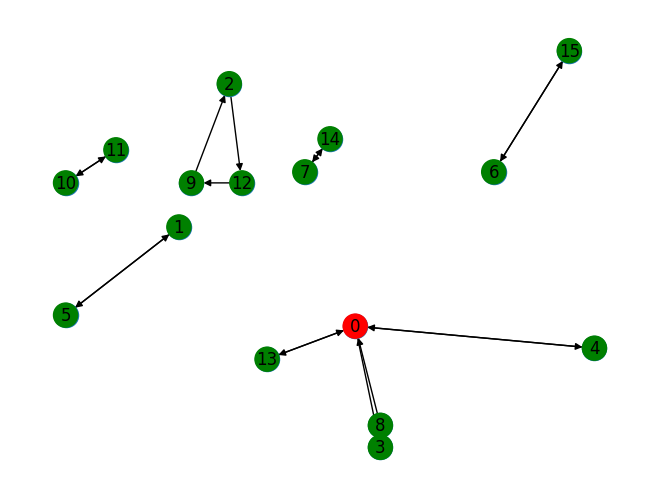

In [37]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
color_map = []
for node in G:
    if node == 0:
        color_map.append('red')
    else:
        color_map.append('green')
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)
nx.draw_networkx_nodes(G, node_color=color_map, pos=my_pos)
nx.draw_networkx_labels(G, pos=my_pos, font_color='black')
plt.show()

In [38]:
# Add the MTZ variables and constraints, and solve
u = m.addVars( G.nodes )

u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

c = m.addConstrs( u[i] - u[j] + Q * x[i,j] <= Q - q[j] for i,j in G.edges if j != depot )
m.Params.TimeLimit = 180
m.optimize()

Set parameter TimeLimit to value 180
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 256 rows, 256 columns and 1140 nonzeros
Model fingerprint: 0xd2761a3b
Variable types: 16 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 9e+01]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 15 rows and 1 columns
Presolve time: 0.00s
Presolved: 241 rows, 255 columns, 2200 nonzeros
Variable types: 15 continuous, 240 integer (240 binary)

Root relaxation: objective 1.699311e+02, 63 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  169.

[(0, 4), (0, 8), (0, 12), (1, 0), (2, 7), (3, 13), (4, 6), (5, 1), (6, 15), (7, 0), (8, 3), (9, 11), (10, 5), (11, 10), (12, 9), (13, 0), (14, 2), (15, 14)]


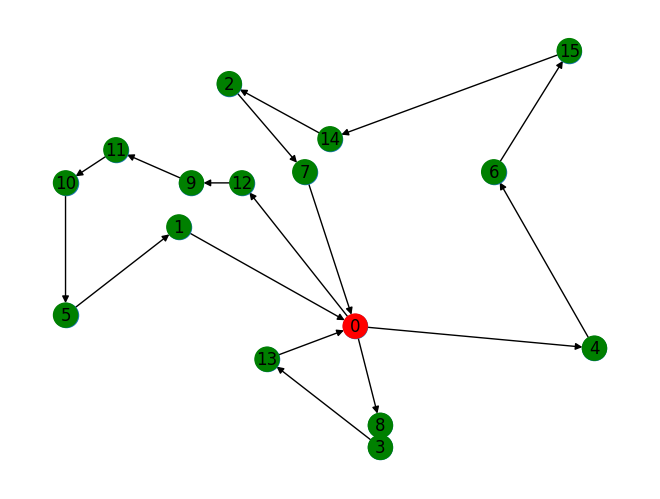

In [39]:
# get the solution and draw it
tour_edges = [e for e in G.edges if x[e].x > 0.5]
print(tour_edges)
color_map = []
for node in G:
    if node == 0:
        color_map.append('red')
    else:
        color_map.append('green')
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)
nx.draw_networkx_nodes(G, node_color=color_map, pos=my_pos)
nx.draw_networkx_labels(G, pos=my_pos, font_color='black')
plt.show()


In [94]:

# Try again, using stronger ("lifted") version of these constraints

m.remove(c)  # remove the previous MTZ constraints
q[depot] = 0
m.addConstrs( u[i] - u[j] + Q * x[i,j] + ( Q - q[i] - q[j] ) * x[j,i] <= Q - q[j] for i,j in G.edges if j != depot )

m.reset()    # start solve process from scratch
m.Params.TimeLimit = 180
m.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 256 rows, 256 columns and 1365 nonzeros
Model fingerprint: 0x52d85d13
Variable types: 16 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 9e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 256 rows, 255 columns, 1518 nonzeros
Variable types: 15 continuous, 240 integer (240 binary)
Found heuristic solution: objective 437.1518170

Root relaxation: objective 2.098610e+02, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  209.86101    0   26  437.15182  209.

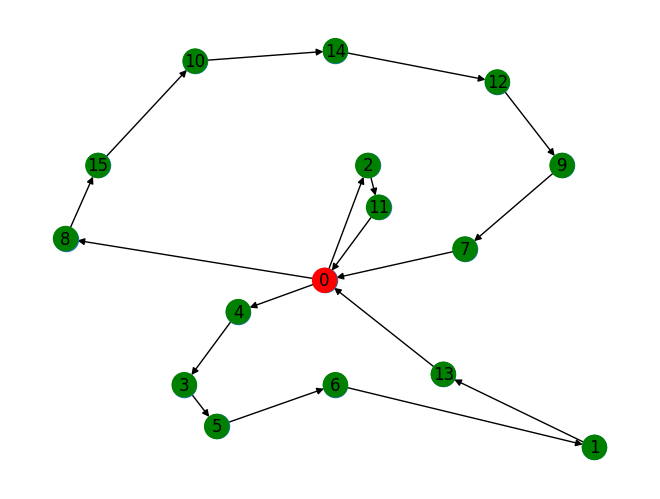

In [95]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
color_map = []
for node in G:
    if node == 0:
        color_map.append('red')
    else:
        color_map.append('green')
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)
nx.draw_networkx_nodes(G, node_color=color_map, pos=my_pos)
nx.draw_networkx_labels(G, pos=my_pos, font_color='black')
plt.show()

In [96]:

obj = m.getObjective()
total_dist = obj.getValue()
print(f"The sum of all the distances covered by {k} vehicles is: {total_dist}")

The sum of all the distances covered by 3 vehicles is: 222.00410899444884
